### Model Build + Tune

In this notebook I tune the hyperparameters of the GBM model.

In [18]:
import sys
sys.path.insert(0, './modules')

# read in the new function
from helpers import get_data
from preprocessor import preprocessor

# other imports

import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [19]:
X, y= get_data('train')
X.head()

,parcelid,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [25]:
#preprocessor copy and pasted from 02_Preprocessing Notebook

In [21]:

class preprocessor:
    
    
    def __init__(self, cols_to_filter=None, datecols=None):
        
        self.cols_to_filter = cols_to_filter
        self.datecols = datecols
        self.was_fit = False
    
    def fit(self, X, y=None):
        """learn any information from the training data we may need to transform the test data"""
        
        # learn from the training data and return the class itself. 
        # allows you to chain fit and predict methods like 
        
        # > p = preprocessor()
        # > p.fit(X).transform(X)
        
        self.was_fit = True
        
        # filter
        X_new = X.drop(self.cols_to_filter, axis=1)
        
        categorical_features = X_new.dtypes[X_new.dtypes == 'object'].index
        self.categorical_features = [x for x in categorical_features if 'date' not in x]
        
        dummied = pd.get_dummies(X_new, columns=self.categorical_features, dummy_na=True)
        self.colnames = dummied.columns
        del dummied
        
        return self
    
    def transform(self, X, y=None):
        """transform the training or test data"""
        # transform the training or test data based on class attributes learned in the `fit` step
        
        if not self.was_fit:
            raise Error("need to fit preprocessor first")
        
        # filter
        X_new = X.drop(self.cols_to_filter, axis=1)

        # dummy code
        X_new = pd.get_dummies(X_new, columns=self.categorical_features, dummy_na=True)
        newcols = set(self.colnames) - set(X_new.columns)
        for x in newcols:
            X_new[x] = 0
            
        X_new = X_new[self.colnames]
                
        # fill NA after we dummy code
        X_new = X_new.fillna(-1)
        
        if self.datecols:
            for x in self.datecols:
                X_new[x + '_month'] = pd.to_datetime(X_new[x]).apply(lambda x: x.month)
                X_new[x + '_year'] = pd.to_datetime(X_new[x]).apply(lambda x: x.year)
                X_new = X_new.drop(x, axis=1)
        
        return X_new
    
    def fit_transform(self, X, y=None):
        """fit and transform wrapper method, used for sklearn pipeline"""

        return self.fit(X).transform(X)

In [22]:
# use preprocess on the training data
p=preprocessor(cols_to_filter = ['rawcensustractandblock', 'censustractandblock', 'propertyzoningdesc', 'regionidneighborhood', 'regionidzip', 'parcelid'], datecols=['transactiondate'])

X = p.fit_transform(X)

In [23]:
X.head()

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,...,propertycountylandusecode_73,propertycountylandusecode_8800,propertycountylandusecode_96,propertycountylandusecode_nan,fireplaceflag_True,fireplaceflag_nan,taxdelinquencyflag_Y,taxdelinquencyflag_nan,transactiondate_month,transactiondate_year
0,1.0,-1.0,-1.0,2.0,3.0,-1.0,4.0,2.0,-1.0,-1.0,...,0,0,0,0,0,1,0,1,1,2016
1,-1.0,-1.0,-1.0,3.5,4.0,-1.0,-1.0,3.5,-1.0,-1.0,...,0,0,0,0,0,1,0,1,1,2016
2,1.0,-1.0,-1.0,3.0,2.0,-1.0,4.0,3.0,-1.0,-1.0,...,0,0,0,0,0,1,0,1,1,2016
3,1.0,-1.0,-1.0,2.0,2.0,-1.0,4.0,2.0,-1.0,-1.0,...,0,0,0,0,0,1,0,1,1,2016
4,-1.0,-1.0,-1.0,2.5,4.0,-1.0,-1.0,2.5,-1.0,-1.0,...,0,0,0,0,0,1,0,1,1,2016


### Define Success

The final model parameters will be based on the evaluation criteria used by the Kaggle competition, Mean Squared Error.

In [24]:
from helpers import mean_abs_error
import inspect
print(inspect.getsource(mean_abs_error))

def mean_abs_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))



### Parameter Tuning and Model Selection
We are still only leveraging the training data

In [31]:
def select_params(X, y, max_estimators=1000, max_depth = 3, learning_rate=0.01):

    # in-time tune set
    X_train, X_tune, y_train, y_tune = train_test_split(X, y, test_size=0.33, random_state=0, shuffle=True)
    
    # out-of-time tune set
    # train_index = X.transactiondate.argsort()[:int(len(X)*0.67)]
    # tune_index = X.transactiondate.argsort()[int(len(X)*0.67):]
    # X_train = X.iloc[train_index]
    # X_tune = X.iloc[tune_index]
    # y_train = y.iloc[train_index]
    # y_tune = y.iloc[tune_index]

    gbm = GradientBoostingRegressor(n_estimators = max_estimators, learning_rate=learning_rate, 
                                    max_depth=max_depth, loss='lad', subsample=0.5)

    gbm.fit(X_train, y_train)

    test_score = np.zeros((max_estimators,), dtype=np.float64)

    for i, y_pred in enumerate(gbm.staged_predict(X_tune)):
        test_score[i] = mean_abs_error(y_tune, y_pred)
        
    print('optimal number of trees: {0}'.format(test_score.argmin()))
    print('best MAE: {0}'.format(test_score.min()))
    print('baseline MAE: {0}'.format(mean_abs_error(y_tune, y_train.median())))
    pd.Series(test_score).plot(title='learning curve for max_depth = {0}'.format(max_depth))
    plt.show()

### Tune Tree Depth
'learning_rate' and 'max_estimators' are indirectly-correlated; the higher the learning rate the fewer trees are needed. Increasing the learning rate will make the models fit faster. This comes with a bit of a hit to accuracy though, so a popular technique is to tune the tree depth with a higher learning rate and then tune the number of trees with a lower learning rate.

***** training for max depth = 2 *****
optimal number of trees: 538
best MAE: 0.0670813421874875
baseline MAE: 0.06803804369747765


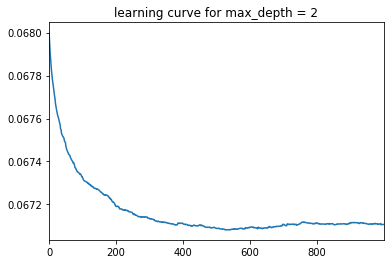

***** training for max depth = 3 *****
optimal number of trees: 435
best MAE: 0.06709945059252274
baseline MAE: 0.06803804369747765


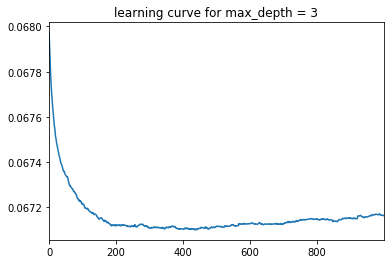

***** training for max depth = 4 *****
optimal number of trees: 182
best MAE: 0.06711932431156699
baseline MAE: 0.06803804369747765


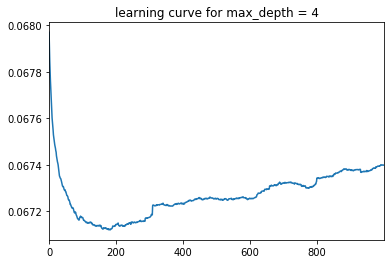

In [33]:
for depth in [2, 3, 4]:
    print('***** training for max depth = {0} *****'.format(depth))
    select_params(X, y, max_estimators=1000, max_depth=depth, learning_rate=0.1)

optimal number of trees: 560
best MAE: 0.06712509883803039
baseline MAE: 0.06803804369747765


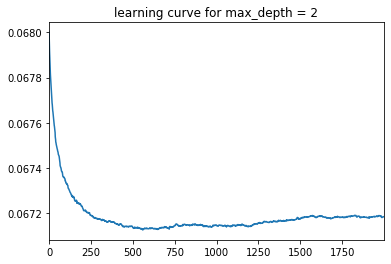

In [34]:
select_params(X, y, max_estimators=2000, max_depth=2, learning_rate=0.1)

### Final Parameters
The final parameters settled on are:


* n_estimators = 1000
* learning_rate = 0.1
* max_depth = 2
* loss = 'lad'
* subsample = 0.5

### Fit and Save the Final Model

In [35]:
import sys
sys.path.insert(0, './modules')

#read in new function
from helpers import get_data, mean_abs_error
from preprocessor import preprocessor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Create Model Object

We'll use a Scikit-Learn Pipeline to combine the preprocessing and GBM steps in one package.

The pipeline object called `my_model` implements `fit` and `predict` methods (among others). When we call the `fit` method, the pipeline will execute `preprocessor.fit_transform()` on the data we pass in the arguments, then pass the results to `GradientBoostingRegressor.fit()`. Similarly, when we call the `predict` method, it will execute `preprocessor.transform()` and then `GradientBoostingRegressor.predict()`.

Another benefit of living into the `fit`, `transform`, `predict` paradigm of Scikit-Learn is that we can add other preprocessing steps (such as PCA) into the pipeline with little modifications to the existing code. Finally, if any of the steps required parameter tuning, we can tune all at once by implementing the steps in a pipeline then using a parameter selection method like Grid Search on the entire pipeline. 

In [41]:
#copy/paste 'preprocessor'

In [39]:
class preprocessor:
    
    
    def __init__(self, cols_to_filter=None, datecols=None):
        
        self.cols_to_filter = cols_to_filter
        self.datecols = datecols
        self.was_fit = False
    
    def fit(self, X, y=None):
        """learn any information from the training data we may need to transform the test data"""
        
        # learn from the training data and return the class itself. 
        # allows you to chain fit and predict methods like 
        
        # > p = preprocessor()
        # > p.fit(X).transform(X)
        
        self.was_fit = True
        
        # filter
        X_new = X.drop(self.cols_to_filter, axis=1)
        
        categorical_features = X_new.dtypes[X_new.dtypes == 'object'].index
        self.categorical_features = [x for x in categorical_features if 'date' not in x]
        
        dummied = pd.get_dummies(X_new, columns=self.categorical_features, dummy_na=True)
        self.colnames = dummied.columns
        del dummied
        
        return self
    
    def transform(self, X, y=None):
        """transform the training or test data"""
        # transform the training or test data based on class attributes learned in the `fit` step
        
        if not self.was_fit:
            raise Error("need to fit preprocessor first")
        
        # filter
        X_new = X.drop(self.cols_to_filter, axis=1)

        # dummy code
        X_new = pd.get_dummies(X_new, columns=self.categorical_features, dummy_na=True)
        newcols = set(self.colnames) - set(X_new.columns)
        for x in newcols:
            X_new[x] = 0
            
        X_new = X_new[self.colnames]
                
        # fill NA after we dummy code
        X_new = X_new.fillna(-1)
        
        if self.datecols:
            for x in self.datecols:
                X_new[x + '_month'] = pd.to_datetime(X_new[x]).apply(lambda x: x.month)
                X_new[x + '_year'] = pd.to_datetime(X_new[x]).apply(lambda x: x.year)
                X_new = X_new.drop(x, axis=1)
        
        return X_new
    
    def fit_transform(self, X, y=None):
        """fit and transform wrapper method, used for sklearn pipeline"""

        return self.fit(X).transform(X)

In [40]:
p = preprocessor(cols_to_filter = ['rawcensustractandblock', 'censustractandblock', 'propertyzoningdesc', 
                                 'regionidneighborhood', 'regionidzip', 'parcelid'], datecols=['transactiondate'])

gbm = GradientBoostingRegressor(n_estimators = 1000, learning_rate=0.1, max_depth=2, loss='lad', subsample=0.5)

my_model = Pipeline([('preprocessor', p), ('regressor', gbm)])

### Fit Final Model

In [42]:
X_train, y_train = get_data('train')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [43]:
my_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 <__main__.preprocessor object at 0x1a67f69fd0>),
                ('regressor',
                 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse',
                                           init=None, learning_rate=0.1,
                                           loss='lad', max_depth=2,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=1000,
                                           n_iter_no_change=None,
                                    

### Score Test Dataset

We will only do this once (or a handful of times) to avoid overfitting the test set. This test dataset was released after the Kaggle competition was over, but is not the same format as what is scored as part of the competition. The final evaluation will be making a Kaggle submission (optional) however we can use this test set to visualize our model results on an out-of-time test set, meaning this data is from another period as data we trained on the model.

In [45]:
X_test, y_test = get_data('test')
y_pred = my_model.predict(X_test)

### Evaluate Model

In [46]:
#using the naive median prediction method
mean_abs_error(y_test, y_train.mean())

0.06992835708871278

In [47]:
#using our actual model
mean_abs_error(y_test, y_pred)

0.06923136602797725

### Plot Model Results

#### Actuals vs. Predictions

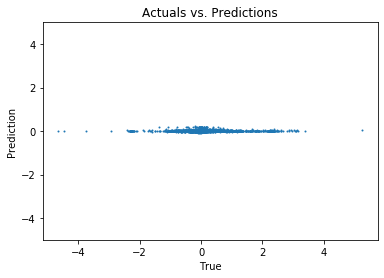

In [49]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, s=1)
ax.set_title('Actuals vs. Predictions')
ax.set_xlabel('True')
ax.set_ylabel('Prediction')
ax.set_ylim(-5, 5)
plt.show()

The plot shows exactly where our lack of predictive power is come from - Our model is predicting every really close to the average or median (probably median given the choice of loss function) instead of making useful predictions.

#### Distribution of Actuals and Predictions

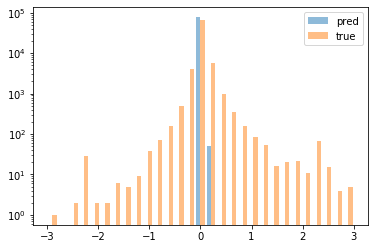

In [51]:
def plot_hists(y_pred, y_true):
    
    fig, ax = plt.subplots()
    bins = np.linspace(-3, 3, 30)
    ax.hist([y_pred, y_true], label=['pred', 'true'], alpha=0.5, bins=bins, log=True)
    plt.legend(loc = 'upper right')
    plt.show()
    
plot_hists(y_pred, y_test)

Notice that our model prediction have far less variance than our true response values.

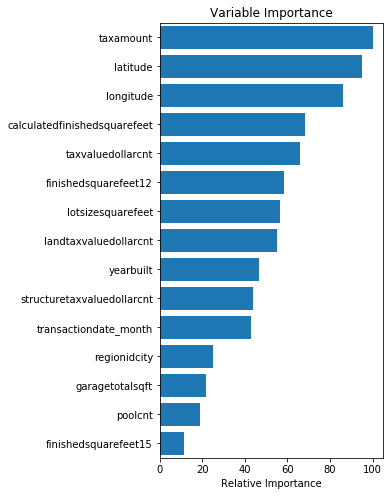

In [54]:
def feat_imp_plot(sk_model, feat_names, N_feature):
    
    feature_importance = sk_model.feature_importances_
    feature_importance = 100.0 * feature_importance / feature_importance.max()
    sorted_idx = np.argsort(feature_importance)
    total_features = sorted_idx.shape[0]
    pos = np.arange(total_features) + .5
    
    fig, ax = plt.subplots(figsize=(4,8))
    ax.barh(pos, feature_importance[sorted_idx], align='center')
    ax.set_yticks(pos)
    ax.set_yticklabels(fnames[sorted_idx])
    ax.set_ylim(total_features-N_feature, total_features)
    ax.set_xlabel('Relative Importance')
   
    plt.title('Variable Importance')
    plt.show()
    
fnames = my_model.steps[0][1].transform(pd.DataFrame(X_test.iloc[0]).T).columns
feat_imp_plot(my_model.steps[1][1], fnames, 15)

These feature importances are on the model for predicting the error between the Zestimate and the actual sale price, so we can conclude that the features are the ones Zillow's model aren't fully capturing signal from.

In [55]:
!mkdir - models

In [57]:
from sklearn.externals import joblib
joblib.dump(my_model, 'models/model.pk1')

['models/model.pk1']